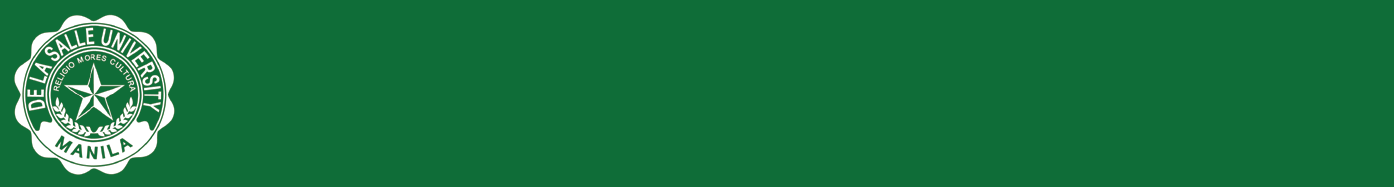

# <center>Seismic Hazard Assessment using Monte Carlo Simulation</center>

## Executive Summary

Statistics of significant earthquakes (Mw ≥ 5.0 and distance ≤ 400 km) are established for a building in Metro Manila based on an earthquake catalog in the past 122 years. Seismic hazard assessment utilizing conventional Probabilistic Seismic Hazard Analysis (PSHA) may be validated using the Monte Carlo Simulation (MCS) method and this notebook presents a framework for performing MCS in Python for seismic hazard assessments. The seismicity of the project site is determined through descriptive statistics of various earthquake parameters which will also serve as input variables for the simulation. This notebook will also highlight common methods, function calls, and visualization tools that are important in statistical studies and random sampling methods.

## Introduction

Prediction of ground motion intensities of different hazard levels is essential, especially in highly urbanized areas like Metro Manila. In this regard, seismic hazard assessments are conducted to aid structural engineers in designing earthquake-resistant structures and ensure that structures are within a desired level of performance. 

**Probabilistic Seismic Hazard Analysis (PSHA)** is a mathematical approach that accounts for the stochastic nature of earthquakes and gives the future ground motions that may occur at a given site. PSHA is composed of five steps (Baker, 2015): (1) identification of sources of potentially damaging earthquakes, (2) characterization of the distribution of earthquake magnitudes, (3) characterization of source-to-site distances of potential earthquakes, (4) prediction of the resulting ground motion intensity, and (5) combining uncertainties in earthquake size, location, and intensity using the total probability theorem. 

From a different perspective, Musson (2012) pointed out that the results of PSHA  may be validated using a quasi-observational approach. **Monte Carlo simulation (MCS)** can be used to generate a synthetic catalog that is compatible with the properties of the seismicity of a site and the known relationship between ground motion, magnitude, and distance. The simulation can be repeated with a large number of trials to produce pseudo-observational data and reduces the problem to a simple *counting of outcomes*. Musson (2000) identified advantages of MCS including adaptability to different seismicity models, flexible handling of uncertainty, adaptability to risk analysis, and conceptually straightforward. On the other hand, disadvantages include non-unique results and long computation time. Monte Carlo simulation can also demonstrate that conventional PSHA does not produce unrealistic results and that the two models are mutually confirmatory.

A historical earthquake catalog from the years 1900 - 2022 was obtained from the United States Geological Survey (USGS) database for a building in Metro Manila and the statistics of major earthquakes (Mw ≥ 5.0 and distance ≤ 400 km) are presented in this notebook. The framework of Monte Carlo Simulation for seismic hazard assessment in Python is also highlighted to provide an alternative means to the conventional PSHA by which the results of MCS can serve as baseline values of earthquake intensities.


## Conceptual Discussion

Monte Carlo simulation can be used to generate synthetic earthquake catalogs via **random sampling** of observed seismicity. The expected ground motion is estimated from the **synthetic catalog** and **empirical attenuation models**, from which seismic hazard is derived. Random variables, such as moment magnitude and source-to-site distance, are simulated by generating uniformly distributed numbers between 0 and 1 and obtaining the corresponding value of the random variable using its CDF plot. The figure below shows the block diagram of Monte Carlo Simulation for earthquake hazard assessment.

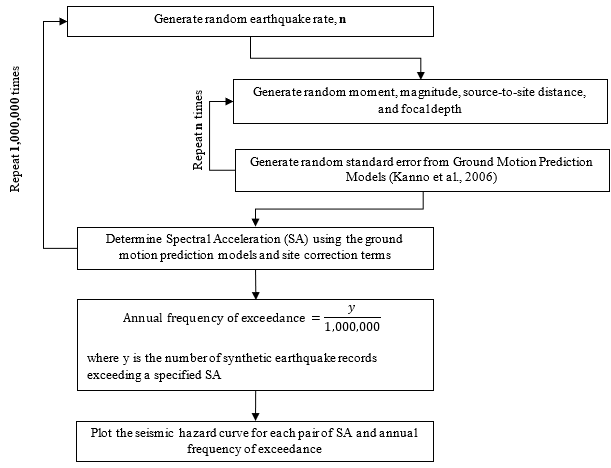

Kanno et al. (2006) developed attenuation models for peak ground acceleration (PGA), 5% damped response spectral acceleration (SA), and peak ground velocity (PGV). Regression models were developed from strong ground motion records of Japan from 1963 to 2003 and 12 earthquakes from other countries to improve the number of near-source data. The ground motion prediction equations (GMPE) were limited only to three parameters: moment magnitude (Mw), source-to-site distance (X), and focal depth (D).

#### Peak Ground Acceleration (PGA) and 5% Damped Response Spectral Acceleration (SA) (Kanno et al., 2006):

**Shallow Event (D $\le$ 30 km):**

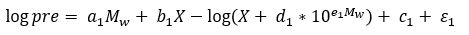

**Deep Event (D > 30km):**



where: 

$M_{w}$ - Moment magnitude, **X**- source-to-site distance, **D**- focal depth

**pre** - predicted peak ground acceleration or spectral acceleration
       
$a_{1}$, $b_{1}$, $c_{1}$, $d_{1}$, $e_{1}$, $a_{2}$, $b_{2}$, $c_{2}$ - regression coefficients

$\epsilon$ - standard normal error


Site correction factors are applied depending on the average shear-wave velocity of the site defined by the following:

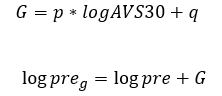

where:

$AVS_{30}$ - average shear wave veloctiy of 30 meters depth of soil

**G** - site-correction term

**p,q** - regression coefficients

$logpre_{g}$ - predicted ground motion considering site effects

Seismic hazard curves are developed for PGA and SA for periods of up to five seconds based on an idealized shear wave velocity (VS30) of 760 m/s. The uniform hazard spectrum for a return period of 43 (50% in 30 years), 475 (10% in 50 years), and 2475 (2% in 50 years) years are developed which can be eventually used for structural design, risk engineering, or comparative studies with those of conventional method.

## Codes

### Import Libraries

The following libraries are needed for this notebook:

* **numpy, scipy, math** - mainly used to handle statistical models, mathematical computations, and random number generators for the simulation

* **pandas** - data manipulation and storage of multi-dimensional arrays

* **folium, seaborn, matplotlib** - data visualization of geographical distribution, histograms, probability mass function, and cumulative distribution function of random variables

* **warnings** - to control warning messages that occasionally arise

In [1]:
import numpy as np
from scipy.stats import norm, poisson
import math

import pandas as pd

import folium
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

The **United States Geological Survey (USGS)** is an agency that monitors natural hazards around the world including earthquakes. They have a vast data of earthquake records which seismologists, engineers, and  scientists can use for statistical studies.

Data downloaded from: https://earthquake.usgs.gov/earthquakes/

**Read csv file using pandas:**

In [2]:
df = pd.read_csv('Earthquake Catalog.csv')

One of the initial steps when importing a dataset is to study its attributes to determine if there would be some form of data cleaning, filtering, or preprocessing before the actual analysis.

In [3]:
df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-11-08T14:30:00.656Z,15.3017,120.8424,168.534,5.2,mww,88.0,104.0,7.480,0.53,...,2022-11-09T14:33:42.291Z,"1 km WSW of Santa Cruz, Philippines",earthquake,9.76,6.240,0.055,32.0,reviewed,us,us
1,2022-10-25T14:59:01.344Z,17.6634,120.8142,13.790,6.4,mww,124.0,25.0,5.134,0.48,...,2022-11-03T12:06:26.045Z,NaN,earthquake,5.67,2.778,0.055,32.0,reviewed,us,us
2,2022-08-27T18:27:36.197Z,17.2931,120.7624,20.398,5.2,mww,169.0,36.0,5.504,0.71,...,2022-11-06T04:39:17.040Z,NaN,earthquake,9.12,3.587,0.063,24.0,reviewed,us,us
3,2022-07-31T18:48:10.312Z,17.2920,120.7158,10.000,5.1,mww,74.0,109.0,5.508,0.75,...,2022-10-12T14:49:20.040Z,"13 km S of San Ramon, Philippines",earthquake,4.36,1.865,0.066,22.0,reviewed,us,us
4,2022-07-31T05:49:59.501Z,17.6548,120.7067,10.000,5.0,mb,109.0,117.0,5.148,0.57,...,2022-10-12T14:49:07.040Z,"0 km NNW of Dolores, Philippines",earthquake,8.21,1.709,0.042,186.0,reviewed,us,us


In [4]:
df.shape

(817, 22)

The data frame consists 817 earthquake records with 22 attributes or columns. 

There are only certain attributes that are needed in the study including: **time, latitude, longitude, depth, mag, magType,** and **place**.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817 entries, 0 to 816
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time             817 non-null    object 
 1   latitude         817 non-null    float64
 2   longitude        817 non-null    float64
 3   depth            817 non-null    float64
 4   mag              817 non-null    float64
 5   magType          817 non-null    object 
 6   nst              153 non-null    float64
 7   gap              221 non-null    float64
 8   dmin             105 non-null    float64
 9   rms              541 non-null    float64
 10  net              817 non-null    object 
 11  id               817 non-null    object 
 12  updated          817 non-null    object 
 13  place            814 non-null    object 
 14  type             817 non-null    object 
 15  horizontalError  100 non-null    float64
 16  depthError       422 non-null    float64
 17  magError        

The information above shows that except for place, the attributes mentioned above does not contain null values and allows us to proceed without performing any data preprocessing. 

### Mapping earthquake records

The project site is located in Quezon City (Latitude: 14.628056ºN, Longitude: 121.068611ºE) and mapping the earthquake records will give the seismicity of the project location in terms of geographical distribution.

In the cell below, a new dataframe is created to isolate columns that will be used for mapping as well as the details that will be displayed.

In [6]:
map_df = df[['latitude', 'longitude', 'mag', 'time', 'place', 'depth']]

In [7]:
map_df

,latitude,longitude,mag,time,place,depth
0,15.3017,120.8424,5.20,2022-11-08T14:30:00.656Z,"1 km WSW of Santa Cruz, Philippines",168.534
1,17.6634,120.8142,6.40,2022-10-25T14:59:01.344Z,NaN,13.790
2,17.2931,120.7624,5.20,2022-08-27T18:27:36.197Z,NaN,20.398
3,17.2920,120.7158,5.10,2022-07-31T18:48:10.312Z,"13 km S of San Ramon, Philippines",10.000
4,17.6548,120.7067,5.00,2022-07-31T05:49:59.501Z,"0 km NNW of Dolores, Philippines",10.000
...,...,...,...,...,...,...
812,13.3590,122.5410,6.59,1907-11-24T13:58:37.460Z,"Luzon, Philippines",15.000
813,15.0200,122.8020,6.43,1907-11-16T22:05:33.890Z,"56 km NE of Casuguran, Philippines",30.000
814,15.1520,121.7960,6.82,1907-07-09T18:54:58.870Z,"24 km N of Panukulan, Philippines",15.000
815,14.6700,123.3820,7.44,1907-04-18T23:52:34.580Z,"70 km NE of Sabang Indan, Philippines",15.000


A function named *magnitude classifier* will cluster the earthquakes into five categories. A new column is added to the map_df dataframe to classify the earthquakes into *feature_groups* that will enable the isolation of these specific groups in the folium map.

In [8]:
def magnitude_classifier(mag):
    if mag >= 5 and mag < 5.85:
        return 'A'
    elif mag >= 5.85 and mag < 6.45:
        return 'B'
    elif mag >= 6.45 and mag < 7.05:
        return 'C'
    elif mag >= 7.05 and mag < 7.65:
        return 'D'
    else:
        return 'E'

The `.map()` method will apply the function to a series in the dataframe.

In [9]:
map_df['maggroup'] = map_df['mag'].map(magnitude_classifier)

In [10]:
map_df

,latitude,longitude,mag,time,place,depth,maggroup
0,15.3017,120.8424,5.20,2022-11-08T14:30:00.656Z,"1 km WSW of Santa Cruz, Philippines",168.534,A
1,17.6634,120.8142,6.40,2022-10-25T14:59:01.344Z,NaN,13.790,B
2,17.2931,120.7624,5.20,2022-08-27T18:27:36.197Z,NaN,20.398,A
3,17.2920,120.7158,5.10,2022-07-31T18:48:10.312Z,"13 km S of San Ramon, Philippines",10.000,A
4,17.6548,120.7067,5.00,2022-07-31T05:49:59.501Z,"0 km NNW of Dolores, Philippines",10.000,A
...,...,...,...,...,...,...,...
812,13.3590,122.5410,6.59,1907-11-24T13:58:37.460Z,"Luzon, Philippines",15.000,C
813,15.0200,122.8020,6.43,1907-11-16T22:05:33.890Z,"56 km NE of Casuguran, Philippines",30.000,B
814,15.1520,121.7960,6.82,1907-07-09T18:54:58.870Z,"24 km N of Panukulan, Philippines",15.000,C
815,14.6700,123.3820,7.44,1907-04-18T23:52:34.580Z,"70 km NE of Sabang Indan, Philippines",15.000,D


### Folium Map

**Base Map**
- to have a scalable circle marker in folium, scalable vector graphics (SVG) was defined using a snip of HTML code to define its properties. The svg rescales when zooming in or out of the folium map which provides better presentation than the basic circle marker.

**Feature Groups**
- to group similar terms, the `.groupby()` method of pandas will initially group the rows by the selected attribute by which unpacking and iteration can be performed. 
- for each record, a scalable circle marker is created with varying sizes and colors depending on the magnitude group while assigning the magnitude as the tooltip and time, place, and depth for the popup. Each record is added to the feature group and the feature group is added to the map.

**Layer Control**
- the feature groups are aggregated in the layer control and the user can isolate magnitude groups of interest.

In [11]:
#building site location
lat = 14.628056
long = 121.068611


#base map
folium_map = folium.Map(location=[lat, long],
                        zoom_start=7, max_zoom=15, min_zoom = 6,
                        tiles="Stamen Terrain")

#site location
folium.Marker(
        location=[lat, long],
        icon=folium.DivIcon(html=f"""
            <svg>
                <circle cx="30" cy="30" r="10" stroke="black" stroke-width="2" fill="#FD02FD" opacity="1"/>| 
            </svg>""")
    ).add_to(folium_map)

#Mapping earthquake records
for magtype, records in map_df.groupby('maggroup'):
    
    feature_group = folium.FeatureGroup(magtype)
    
    for record in records.itertuples():
        r = 10
        if magtype == 'A':
            rad = r
            color = '#02FD74'
        elif magtype == 'B':
            rad = r*1.5
            color = '#DBFD02'
        elif magtype == 'C':
            rad = r*2
            color = '#FDCC02'
        elif magtype == 'D':
            rad = r*2.5
            color = '#FD7C02'
        elif magtype == 'E':
            rad = r*3 
            color = '#FD0202'

        folium.Marker(
                location=[record.latitude, record.longitude],
                tooltip =  'Mag = ' + str(record.mag),
                popup = folium.Popup(
                    'Time:' + str(record.time[:10]) + '\n' 
                    + 'Location: ' + str(record.place)[:-13] + '\n' 
                    + 'Depth: ' + str(round(record.depth,1)) + ' km', 
                    max_width = '90'),
                icon=folium.DivIcon(html=f"""
                    <svg>
                        <circle cx="30" cy="30" r={rad} stroke="black" stroke-width="1" fill={color} opacity="0.7"/>
                    </svg>""")
            ).add_to(feature_group)
    
    feature_group.add_to(folium_map)

#Layer Control for feature groups
folium.LayerControl().add_to(folium_map)

folium_map

### Statistics of Major Earthquakes 

The following visualizations show the distributions of several earthquake parameters that will be later used for Monte Carlo simulation. The earthquake catalog is assumed to be declustered of foreshocks and aftershocks such that no dependent events exist in the records. 

#### Earthquake Rate

Poisson distribution gives the discrete probability distribution of a given number of independent events with a constant mean rate over a specified time. Wang et al (2014) verified the Poisson model to be suitable for earthquake engineering practices. The poisson distribution is given by the formula:

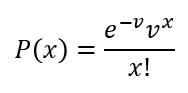

where v is the mean annual rate of earthquakes and x is the number of earthquakes per year.

In the code below, `mean_rate` is determined by dividing the total number of earthquake records obtained by the number of years.

In [12]:
#No. of earthquakes in the record
eq_count = df.shape[0]

#No. of years: 1900 - 2022
year_count = 122

mean_rate = eq_count / year_count

In [13]:
mean_rate

6.69672131147541

The **probability mass function (PMF)** and **cumulative distribution function (CDF)** of the earthquake rates are obtained using the *poisson function* of **scipy** library. Since the mean rate calculated is around 6 earthquakes per year, the probability for 0-15 earthquakes are obtained using the code below.

In [14]:
#0-15 earthquakes
eq_bins = np.arange(0,16,1)

#Probability Mass Function
eq_rate = poisson.pmf(eq_bins, mean_rate)

#Cumulative Distribution Function
eq_cdf = poisson.cdf(eq_bins, mean_rate)

In [15]:
eq_bins

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [16]:
eq_rate

array([0.00123495, 0.00827014, 0.02769143, 0.06181392, 0.10348766,
       0.1386056 , 0.15470051, 0.14799803, 0.12388769, 0.09218237,
       0.06173197, 0.03758198, 0.020973  , 0.01080387, 0.0051679 ,
       0.0023072 ])

In [17]:
eq_cdf

array([0.00123495, 0.0095051 , 0.03719653, 0.09901045, 0.20249811,
       0.3411037 , 0.49580421, 0.64380224, 0.76768994, 0.85987231,
       0.92160428, 0.95918626, 0.98015926, 0.99096314, 0.99613103,
       0.99843823])

In the succeeding visualizations, **seaborn** library is used to graph the statistics either by barplot, lineplot, or regplot and will be modified using the **matplotlib** library. Seaborn is a data visualization library based from matplotlib but uses simpler syntax and can handle data frames better than matplotlib.

#### Plot of Earthquake Rate

The `sns.barplot()` function is used to initially graph the PMF of earthquake rates and the succeeding codes are matplotlib modifiers. 

The `plt.subplots()` function returns a tuple containing the figure and axes objects which can be unpacked. It provides a more concise assignment of figure and axes than the `plt.figure()` method call. Method calls such as `ax.set_title()`, `ax.set_xlabel`, and `ax.set_ylim` are used to modify the seaborn plot for better visualization. In line 14, `ax2=ax.twinx()` allows us to overlay a new plot by assigning `ax2` as a *twin axis* of `ax`. In this way, a new plot may be used with the y-axis located on the other side of the plot.

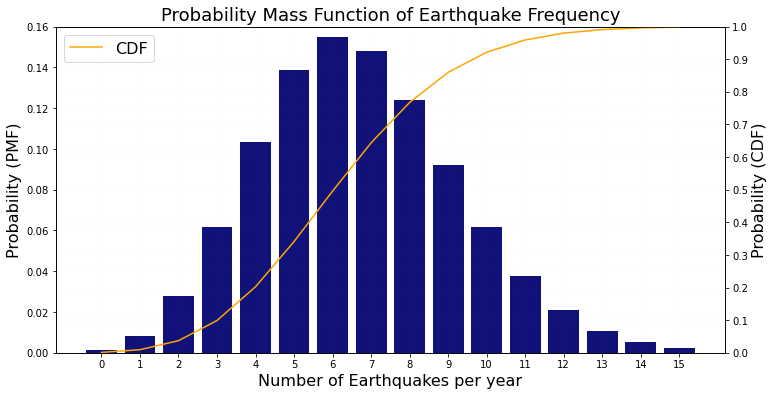

In [18]:
fig, ax = plt.subplots(figsize=(12,6))

sns.barplot(x=eq_bins, y=eq_rate, color='darkblue')

ax.set_title('Probability Mass Function of Earthquake Frequency', fontsize= 18)

ax.set_xlabel('Number of Earthquakes per year', fontsize=16)

ax.set_ylabel('Probability (PMF)', fontsize=16)
ax.set_ylim(0,0.16)

ax.grid(axis= 'both', alpha= 0.01)

ax2=ax.twinx()
sns.lineplot(x=eq_bins, y=eq_cdf, color='orange')

ax2.set_ylim(0,1.0)
ax2.set_yticks(np.arange(0,1.1,0.1))
ax2.set_ylabel('Probability (CDF)', fontsize=16)

ax2.grid(axis='both', alpha=0.01)

ax2.legend(['CDF'], fontsize=16, loc=2);

The plot of earthquake rate shows that the most likely number of earthquakes per year in the project site is six earthquakes per year. 

#### Magnitude

Magnitude scales in the dataset are varying and conversion of each value to a single scale is needed for consistency. From the results of `.value_counts()` method, the three magnitude scales used are surface-wave magnitude (ms), body-wave magnitude (mb), and moment magnitude (mw).

In [19]:
mag_df = df[['mag', 'magType']]
mag_df['magType'].value_counts()

mb     340
mw     232
mwc    114
mww     67
ms      36
mwb     28
Name: magType, dtype: int64

Ground motion models are usually defined in terms of the moment magnitude which requires the conversion of other magnitude types. Tang et al. (2016) performed General Orthogonal Regression (GOR) method to develop empirical equations for the conversion of surface-wave and body-wave magnitude to moment magnitude based on the earthquake catalog of Western China from the China Earthquake Data Center (CEDC). The empirical equations are given as follows:

* **Mw** = -0.55 + 1.16 x **mb**
* **Mw** = 1.61 + 0.69 x **ms**

The function below is an implementation of the conversion formulas above.

In [20]:
#magnitude converter function

def magnitude_converter(magtype, mag):
    if magtype == 'mb':
        return round(-0.55+1.16*mag,2)
    elif magtype == 'ms':
        return round(1.61+0.69*mag,2)
    else:
        return mag

The `np.vectorize()` method is used to transform functions to become *numpy-aware* and provides faster implementation compared to other methods (e.g. `.apply()`). Since the initial function expects a single value of `magType` and `mag`, an array can now be an input due to the *vectorization* of function.

In [21]:
#convert magnitude
mag_df['magnitude'] = np.vectorize(magnitude_converter)(mag_df['magType'], mag_df['mag'])

In [22]:
mag_df.head()

,mag,magType,magnitude
0,5.2,mww,5.20
1,6.4,mww,6.40
2,5.2,mww,5.20
3,5.1,mww,5.10
4,5.0,mb,5.25


Random samples are obtained using `.sample()` to see the new values of the magnitude in terms of Mw scale. The dataframe below shows that most of the magnitude increased when converted to Mw scale.

In [23]:
#pick random 
mag_df[(mag_df['magType'] == 'mb') | (mag_df['magType'] == 'ms')].sample(5)

,mag,magType,magnitude
96,5.0,mb,5.25
511,5.6,ms,5.47
552,5.1,mb,5.37
597,5.0,mb,5.25
510,5.1,mb,5.37


A frequency distribution of the dataset can be obtained by using the `np.histogram()` function which returns the count of instances for a specified interval. The intervals are assigned in the `bin` argument of the function and for this case, the bins are from magnitude 5.0 to 8.0 with 0.1 intervals.

The output of `np.histogram()` can be unpacked into `freq` and `mag_bins` in order to calculate the cumulative distribution function using the frequency.

In [24]:
freq, mag_bins = np.histogram(mag_df['magnitude'], bins=np.arange(5,8.1,0.1))

The CDF of a random variable is calculated by dividing the cumulative sum over the total number of earthquake records.

In [25]:
mag_cdf= freq.cumsum()/freq.sum()

In [26]:
mag_bins

array([5. , 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2,
       6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5,
       7.6, 7.7, 7.8, 7.9, 8. ])

In [27]:
mag_cdf

array([0.03304774, 0.07099143, 0.28029376, 0.41860465, 0.52876377,
       0.59730722, 0.68298654, 0.750306  , 0.79559364, 0.85679315,
       0.88372093, 0.90697674, 0.9253366 , 0.93145655, 0.94614443,
       0.95716034, 0.9620563 , 0.96940024, 0.97429621, 0.97919217,
       0.98286414, 0.98531212, 0.98653611, 0.98898409, 0.99265606,
       0.99510404, 0.99877601, 1.        , 1.        , 1.        ])

#### Plot of Earthquake Rate

The magnitudes discretized at 0.1 are plotted using the `sns.histplot()` function. Initially, the tick marks of the graph are left-aligned and subtracting half of the interval (i.e. 0.1/2=0.05) in the `bins` argument will center the tick marks. The `shrink` argument reduces the size of the bars for better readbility of the graph. 

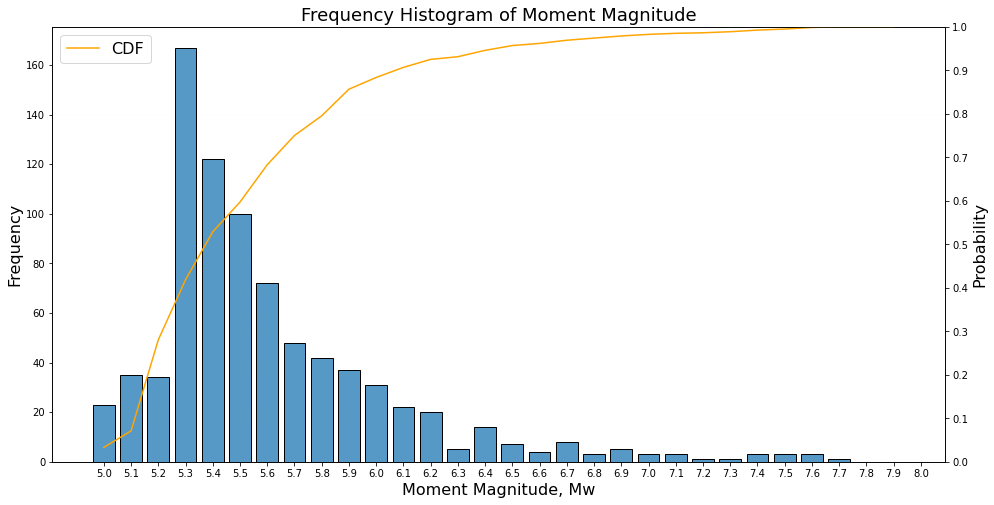

In [28]:
fig, ax = plt.subplots(figsize=(16,8))

sns.histplot(mag_df['magnitude'], bins=mag_bins-0.05, shrink=0.8)

ax.set_title('Frequency Histogram of Moment Magnitude', fontsize= 18)

ax.set_xticks(mag_bins)
ax.set_xlabel('Moment Magnitude, Mw', fontsize=16)

ax.set_ylabel('Frequency', fontsize=16)

ax.grid(axis= 'both', alpha= 0.01)

ax2=ax.twinx()
sns.lineplot(x=mag_bins[:-1], y=mag_cdf, color='orange')

ax2.set_ylim(0,1.0)
ax2.set_yticks(np.arange(0,1.1,0.1))
ax2.set_ylabel('Probability', fontsize=16)

ax2.grid(axis='both', alpha=0.01)

ax2.legend(['CDF'], fontsize=16, loc=2);

The frequency histogram shows that at the event of an earthquake, there is a high probability that the earthquake would have a magnitude of 5.3.

### Distance

The distance of an earthquake event from a specific site can be obtained using the Haversine formula. Haversine formula calculates the distance between two points on a sphere given the latitude and longitude of each.

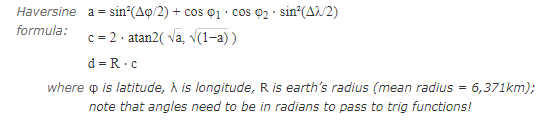

In [29]:
dist_df = df[['latitude', 'longitude']]

In [30]:
dist_df

,latitude,longitude
0,15.3017,120.8424
1,17.6634,120.8142
2,17.2931,120.7624
3,17.2920,120.7158
4,17.6548,120.7067
...,...,...
812,13.3590,122.5410
813,15.0200,122.8020
814,15.1520,121.7960
815,14.6700,123.3820


The next lines of code are similar to the implementation of statistics of magnitude. Functions such as `np.vectorize()`, `np.histogram()`, and `plt.subplots()` are used to determine the PDF and CDF of earthquake distance.

In [31]:
def find_distance(lat1, lon1, lat2, lon2):
    radius = 6371 

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance_bw_ori_desti = radius * c
    return round(distance_bw_ori_desti)

In [32]:
dist_df['distance'] = np.vectorize(find_distance)(lat, long, dist_df['latitude'], dist_df['longitude'])

In [33]:
dist_df

,latitude,longitude,distance
0,15.3017,120.8424,79
1,17.6634,120.8142,339
2,17.2931,120.7624,298
3,17.2920,120.7158,299
4,17.6548,120.7067,339
...,...,...,...
812,13.3590,122.5410,212
813,15.0200,122.8020,191
814,15.1520,121.7960,97
815,14.6700,123.3820,249


In [34]:
freq, dist_bins = np.histogram(dist_df['distance'],bins=np.arange(0,410,5))

In [35]:
dist_cdf= freq.cumsum()/freq.sum()

In [36]:
dist_bins

array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125,
       130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190,
       195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255,
       260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320,
       325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385,
       390, 395, 400, 405])

In [37]:
dist_cdf

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00122399, 0.00122399, 0.00489596, 0.0122399 ,
       0.01713586, 0.02692778, 0.04528764, 0.05875153, 0.08200734,
       0.11505508, 0.14075887, 0.15667075, 0.19339045, 0.21664627,
       0.23867809, 0.25826193, 0.28151775, 0.31946144, 0.33537332,
       0.35373317, 0.37086903, 0.37576499, 0.39412485, 0.40636475,
       0.4247246 , 0.44063647, 0.45287638, 0.48225214, 0.500612  ,
       0.51774786, 0.54345165, 0.56425949, 0.58384333, 0.59485924,
       0.60587515, 0.62178703, 0.63647491, 0.6499388 , 0.66462668,
       0.67319461, 0.67564259, 0.68910649, 0.69645043, 0.71113831,
       0.72582619, 0.74051408, 0.750306  , 0.75642595, 0.7747858 ,
       0.79192166, 0.80783354, 0.81395349, 0.82374541, 0.83476132,
       0.84210526, 0.85312118, 0.86903305, 0.87760098, 0.88494492,
       0.89106487, 0.89596083, 0.90208078, 0.9130967 , 0.93023

#### Plot of Earthquake Distances

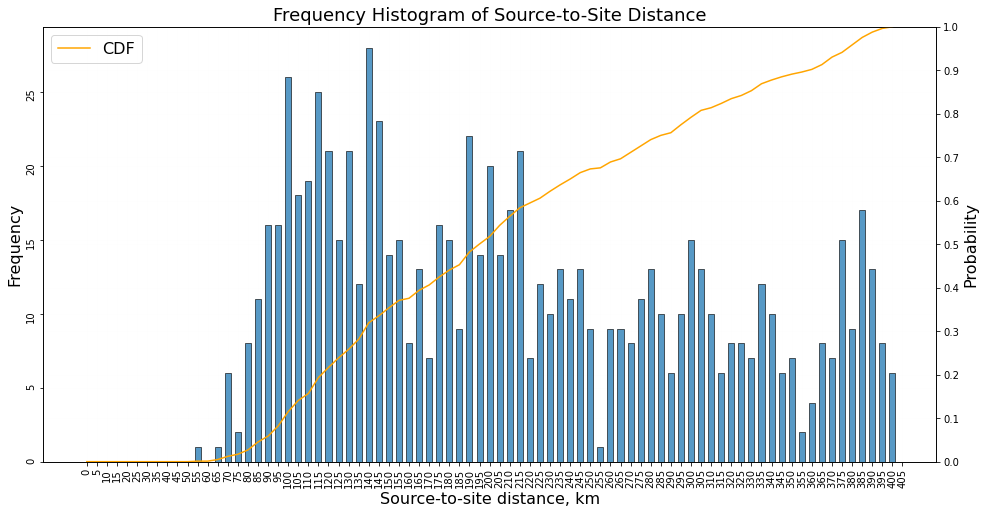

In [38]:
fig, ax = plt.subplots(figsize=(16,8))

sns.histplot(dist_df['distance'], bins=dist_bins-2.5, shrink=0.6)

ax.set_title('Frequency Histogram of Source-to-Site Distance', fontsize= 18)

ax.set_xticks(dist_bins)
ax.set_xlabel('Source-to-site distance, km', fontsize=16)
ax.tick_params(which='major', labelrotation=90)

ax.set_ylabel('Frequency', fontsize=16)

ax.grid(axis= 'both', alpha= 0.01)

ax2=ax.twinx()
sns.lineplot(x=dist_bins[:-1], y=dist_cdf, color='orange')

ax2.set_ylim(0,1.0)
ax2.set_yticks(np.arange(0,1.1,0.1))
ax2.set_ylabel('Probability', fontsize=16)

ax2.grid(axis='both', alpha=0.01)

ax2.legend(['CDF'], fontsize=16, loc=2);

### Focal Depth

The focal depth can be classified into two: shallow and deep events, which was adopted from the attenuation model in the study of Kanno et al (2006). The earthquake is a shallow event if the focal depth is less than 30km, otherwise it is a deep event. 

The `.map()` method is used to classify each earthquake record in the dataframe by defining an anonymous function using the `lambda` function.

In [39]:
depth_df = df['depth'].map(lambda x: 'shallow' if x <= 30 else 'deep')

In [40]:
depth_df

0         deep
1      shallow
2      shallow
3      shallow
4      shallow
        ...   
812    shallow
813    shallow
814    shallow
815    shallow
816    shallow
Name: depth, Length: 817, dtype: object

### Plot of Focal Depth

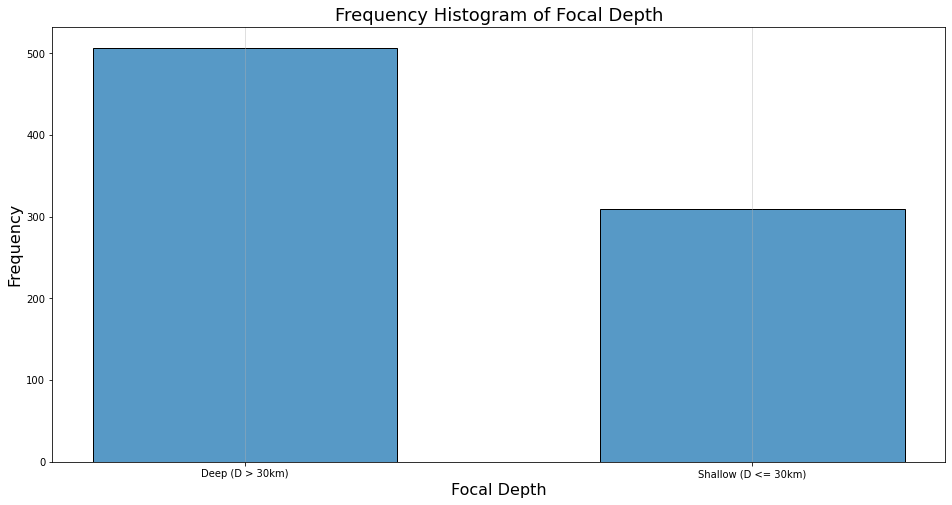

In [41]:
fig, ax = plt.subplots(figsize=(16,8))

sns.histplot(depth_df, shrink=0.6)

ax.set_title('Frequency Histogram of Focal Depth', fontsize= 18)

ax.set_xticklabels(['Deep (D > 30km)', 'Shallow (D <= 30km)'])
ax.set_xlabel('Focal Depth', fontsize=16)

ax.set_ylabel('Frequency', fontsize=16)

ax.grid(axis= 'x', alpha= 0.5)

The plot of focal depth shows that almost two-thirds of the earthquakes happened more than 30 km below the surface. 

The series `depth_df` is redefined numerically in order to use the parameter for Monte Carlo Simulation.

In [42]:
depth_df=df['depth']

In [43]:
depth_df

0      168.534
1       13.790
2       20.398
3       10.000
4       10.000
        ...   
812     15.000
813     30.000
814     15.000
815     15.000
816     15.000
Name: depth, Length: 817, dtype: float64

In [44]:
freq, depth_bins = np.histogram(depth_df, bins=[0, 30, depth_df.max()])

In [45]:
depth_bins

array([  0.,  30., 256.])

In [46]:
depth_cdf = freq.cumsum()/freq.sum()

In [47]:
depth_cdf

array([0.37576499, 1.        ])

### Correlation of Magnitude and Distance

Before proceeding with the simulation, it is important to establish the correlation between random variables. If a correlation exists, there is a need to perform transformation techniques before proceeding with the simulation.

The code below concatenates the magnitude from the `mag_df` dataframe and distance from the `dist_df` dataframe using the `pd.concat()` method call. The argument `axis` is assigned with a value of 1 to indicate that the two series are added as columns and not as rows.

In [48]:
corr = pd.concat([mag_df['magnitude'], dist_df['distance']], axis= 1)

In [49]:
corr

,magnitude,distance
0,5.20,79
1,6.40,339
2,5.20,298
3,5.10,299
4,5.25,339
...,...,...
812,6.59,212
813,6.43,191
814,6.82,97
815,7.44,249


The correlation coefficient between the magnitude and distance can be calculated using the `np.corrcoef()` function. This function returns a matrix of correlations between variables.


In [50]:
np.corrcoef(corr.magnitude, corr.distance)

array([[1.       , 0.0540639],
       [0.0540639, 1.       ]])

The correlation coefficient is selected by indexing the array with the value rounded to four decimal places. 

In [51]:
#correlation

r2 = round(np.corrcoef(corr.magnitude, corr.distance)[0,1],4)

### Plot of correlation between magnitude and distance

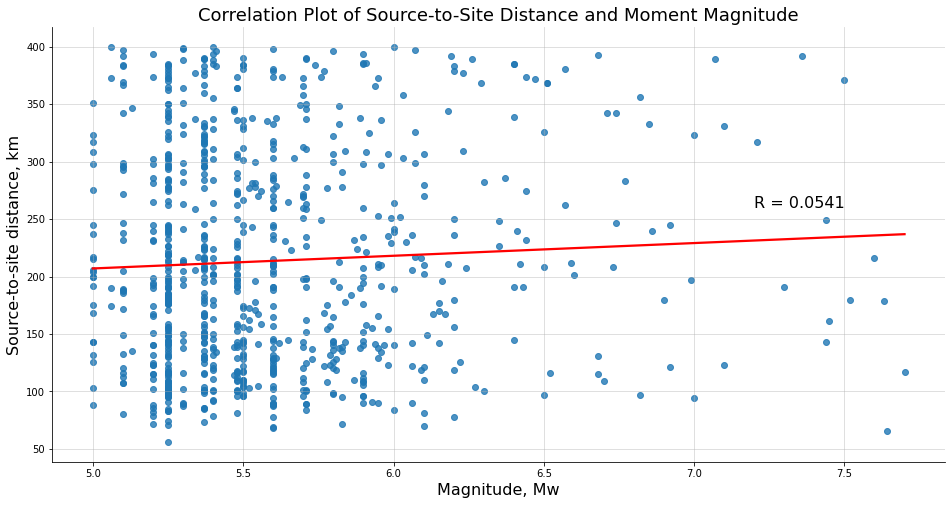

In [52]:
fig, ax = plt.subplots(figsize=(16,8))

sns.regplot(data = corr, x='magnitude', y='distance', ci= False, line_kws ={'color':'red'})
sns.despine()

ax.set_title('Correlation Plot of Source-to-Site Distance and Moment Magnitude', fontsize= 18)

ax.set_xlabel('Magnitude, Mw', fontsize=16)

ax.set_ylabel('Source-to-site distance, km', fontsize=16)

ax.grid(alpha= 0.5)

ax.annotate(f'R = {r2}', (7.2, 260), fontsize= 16);


The figure above shows that there is no correlation between magnitude and distance as the value of R is close to 0.

### Monte Carlo Simulation Function


After defining the statistics of earthquake parameters and obtaining their respective CDFs, the function that would perform the Monte Carlo Simulation is defined in the following lines of code.


The function would need three inputs namely, the period of the structure, the number of earthquake events, and the AVS30 which is a measure of a property of soil in the site. The output of the function will be a dataframe corresponding to the pseudo-earthquake records of the location.

#### Ground Motion Prediction Models coefficients

The regression coefficients of the prediction models are imported using the `.read_csv()` method of pandas with the period of the structure as the index.

In [53]:
#import regression coefficients

shallow_coeff = pd.read_csv('shallow events.csv', index_col=0)
deep_coeff = pd.read_csv('deep events.csv', index_col=0)
site_correction = pd.read_csv('site correction.csv', index_col=0)

In [54]:
shallow_coeff

,a1,b1,c1,d1,e1,error1
period,,,,,,
0.00,0.56,-0.0031,0.26,0.0055,0.5,0.37
0.05,0.54,-0.0035,0.48,0.0061,0.5,0.37
0.06,0.54,-0.0037,0.57,0.0065,0.5,0.38
0.07,0.53,-0.0039,0.67,0.0066,0.5,0.38
0.08,0.52,-0.0040,0.75,0.0069,0.5,0.39
0.09,0.52,-0.0041,0.80,0.0071,0.5,0.40
0.10,0.52,-0.0041,0.85,0.0073,0.5,0.40
0.11,0.50,-0.0040,0.96,0.0061,0.5,0.40
0.12,0.51,-0.0040,0.93,0.0062,0.5,0.40


In [55]:
deep_coeff

,a2,b2,c2,error2
period,,,,
0.00,0.41,-0.0039,1.56,0.40
0.05,0.39,-0.0040,1.76,0.42
0.06,0.39,-0.0041,1.86,0.43
0.07,0.38,-0.0042,1.96,0.45
0.08,0.38,-0.0042,2.03,0.45
0.09,0.38,-0.0043,2.08,0.46
0.10,0.38,-0.0043,2.12,0.46
0.11,0.38,-0.0044,2.14,0.46
0.12,0.38,-0.0044,2.14,0.46


In [56]:
site_correction

,p,q
period,,
0.00,-0.55,1.35
0.05,-0.32,0.80
0.06,-0.26,0.65
0.07,-0.24,0.60
0.08,-0.26,0.64
0.09,-0.29,0.72
0.10,-0.32,0.78
0.11,-0.35,0.84
0.12,-0.39,0.94


In [57]:
shallow_coeff.index

Float64Index([ 0.0, 0.05, 0.06, 0.07, 0.08, 0.09,  0.1, 0.11, 0.12, 0.13, 0.15,
              0.17,  0.2, 0.22, 0.25,  0.3, 0.35,  0.4, 0.45,  0.5,  0.6,  0.7,
               0.8,  0.9,  1.0,  1.1,  1.2,  1.3,  1.5,  1.7,  2.0,  2.2,  2.5,
               3.0,  3.5,  4.0,  4.5,  5.0],
             dtype='float64', name='period')

#### Unpacking of coefficients from the dataframe

The index of each dataframe for the regression coefficients of the prediction models is the period of the structure, and the `.loc[]` method can be used to obtain the coefficients and unpack them to several variables. 

In [58]:
a1,b1,c1,d1,e1,error1 = shallow_coeff.iloc[0]
print(a1,b1,c1,d1,e1,error1)

0.56 -0.0031 0.26 0.0055 0.5 0.37


#### Random generation of magnitude, source, and depth

A uniformly distributed number between 0 and 1 is generated using the `np.random.uniform()` method as shown below.

In [59]:
np.random.uniform(0,1)

0.003540585260256024

Initially, the CDF of each random variable was determined and plotted in the above visualizations. In the code below, the CDF will be used as the bins for `np.digitize()` method wherein `np.digitize()` returns the index of the random variable corresponding to that CDF. 

In [60]:
np.digitize(np.random.uniform(0,1), mag_cdf)

3

Finally, the value of the random variable is obtained by passing the index into their respective bins and using `np.around()` to round off the value.

In [61]:
np.around(mag_bins[np.digitize(np.random.uniform(0,1), mag_cdf)],1)

6.0

For the standard normal error, the `norm.ppf()` method of *scipy* is used to return the inverse CDF of a given value.

In [62]:
norm.ppf(np.random.uniform(0,1))

-1.5355794077221976

In [63]:
def monte_carlo(period, n, AVS30):
    
    #gravitational acceleration
    g= 980.665
    
    #Unpacking of coefficients from the dataframe
    #regression coefficients and site correction coefficients
    a1,b1,c1,d1,e1,error1 = shallow_coeff.loc[period]
    a2,b2,c2,error2 = deep_coeff.loc[period]
    p,q = site_correction.loc[period]
    
    #site correction term calculation
    G = p* math.log10(AVS30) + q
    
    #Create dataframe for the simulation
    df = pd.DataFrame(columns=['magnitude','source_distance', 'focal_depth', 'error', 'logpre', 'G', 'logpre-g', 
                               'predicted'])
    
    #Random generation of magnitude, source, depth, and model error
    df['magnitude'] = np.around(mag_bins[np.digitize(np.random.uniform(0,1,n), mag_cdf)],1)
    df['source_distance'] = dist_bins[np.digitize(np.random.uniform(0,1,n), dist_cdf)]
    df['focal_depth'] = ['shallow' if x==0 else 'deep' 
                         for x in depth_bins[np.digitize(np.random.uniform(0,1,n), depth_cdf)]]
    error = norm.ppf(np.random.uniform(0,1,n))
    df['error'] = np.where(df.focal_depth == 'shallow', error*error1, error*error2)
    df['G'] = G
    
    #prediction models for shallow and deep events
    def spec_accel(magnitude, source, depth, error):
        if depth == 'shallow':
            return a1*magnitude + b1*source - math.log10(source + d1*10**(e1*magnitude)) + c1 + error
        else:
            return a2*magnitude + b2*source - math.log10(source) + c2 + error
        
    df['logpre'] = np.vectorize(spec_accel)(df.magnitude, df.source_distance, df.focal_depth, df.error)        
    df['logpre-g'] = df['logpre'] + df['G']
    df['predicted'] = df['logpre-g'].apply(lambda x: (10**(x))/g)
    
    return df

### Monte Carlo Simulation

In the simulations below, the *Peak Ground Acceleration (i.e. period= 0)* is simulated and the effect of the number of trials is studied by varying the specified number of years.

#### Trial 1: 10,000 years

In [64]:
no_of_years = 10_000

To determine the number of earthquakes that would occur within a 10,000 year period, the number of earthquake per year is randomized using the poisson distribution model. The `np.random.poisson` is used to perform the randomization with the `mean_rate` and `no_of_years` as arguments.

The array below shows that on the first year, there would be eight earthquakes, eleven earthquakes on the second year, eight earthquakes on the third year until the four earthquake events on the 100,000th year.

In [65]:
np.random.poisson(mean_rate, no_of_years)

array([ 8, 11,  8, ...,  6,  3,  4])

The array above is then added to determine the total number of earthquake events for a specific time period.

In [66]:
no_of_eq = np.random.poisson(mean_rate, no_of_years).sum()

Since the mean rate of earthquake is around 6 earthquakes per year as defined in the above statistics, the 66915 earthquake events for a 10,000-year period is a reasonable result.

In [67]:
no_of_eq

66915

The Monte Carlo Simulation is initiated by entering the `period`, `no_of_eq`, and `AVS30` in the function.

In [68]:
PGA_df = monte_carlo(0, no_of_eq, 760)
PGA_df

,magnitude,source_distance,focal_depth,error,logpre,G,logpre-g,predicted
0,5.5,215,shallow,-0.255151,0.079707,-0.234447,-0.154740,0.000714
1,6.5,315,deep,0.326026,0.824215,-0.234447,0.589768,0.003965
2,5.5,285,deep,-0.574762,-0.326107,-0.234447,-0.560554,0.000280
3,5.8,195,deep,-0.350394,0.537071,-0.234447,0.302624,0.002047
4,5.6,360,deep,-0.602299,-0.706601,-0.234447,-0.941049,0.000117
...,...,...,...,...,...,...,...,...
66910,5.6,175,shallow,0.091194,0.693128,-0.234447,0.458680,0.002932
66911,5.3,375,shallow,-0.253570,-0.764937,-0.234447,-0.999385,0.000102
66912,5.4,115,shallow,0.444934,1.301449,-0.234447,1.067001,0.011898
66913,5.7,215,deep,-0.171752,0.554309,-0.234447,0.319862,0.002130


#### Trial 2: 100,000 years

In [69]:
no_of_trials = 100_000
no_of_eq = np.random.poisson(mean_rate, no_of_trials).sum()

In [70]:
no_of_eq

671010

In [71]:
PGA_df_2 = monte_carlo(0, no_of_eq, 760)
PGA_df_2

,magnitude,source_distance,focal_depth,error,logpre,G,logpre-g,predicted
0,6.0,150,deep,0.137176,1.396085,-0.234447,1.161638,0.014795
1,5.3,205,deep,-0.050048,0.571698,-0.234447,0.337251,0.002217
2,5.3,115,deep,0.379256,1.603058,-0.234447,1.368610,0.023828
3,5.5,300,deep,0.303552,0.471431,-0.234447,0.236983,0.001760
4,5.2,100,shallow,0.463991,1.316584,-0.234447,1.082137,0.012320
...,...,...,...,...,...,...,...,...
671005,5.9,95,deep,0.138596,1.769373,-0.234447,1.534925,0.034947
671006,5.4,240,deep,0.380344,0.838133,-0.234447,0.603685,0.004094
671007,5.3,280,shallow,0.083335,-0.007617,-0.234447,-0.242065,0.000584
671008,5.3,190,deep,0.206608,0.919854,-0.234447,0.685407,0.004942


#### Trial 3: 1,000,000 years

In [72]:
no_of_trials = 1_000_000
no_of_eq = np.random.poisson(mean_rate, no_of_trials).sum()
no_of_eq

6699203

In [73]:
PGA_df_3 = monte_carlo(0, no_of_eq, 760)
PGA_df_3

,magnitude,source_distance,focal_depth,error,logpre,G,logpre-g,predicted
0,6.2,305,deep,0.617676,1.045877,-0.234447,0.811429,0.006606
1,5.4,365,deep,0.145267,-0.066525,-0.234447,-0.300973,0.000510
2,5.4,235,deep,0.236248,0.722680,-0.234447,0.488232,0.003138
3,6.3,215,deep,0.437729,1.409791,-0.234447,1.175343,0.015269
4,5.6,265,shallow,-0.224078,-0.078474,-0.234447,-0.312921,0.000496
...,...,...,...,...,...,...,...,...
6699198,5.3,185,shallow,0.246609,0.628208,-0.234447,0.393761,0.002525
6699199,5.2,210,shallow,0.354328,0.548604,-0.234447,0.314156,0.002102
6699200,5.3,370,deep,-0.753917,-1.032118,-0.234447,-1.266566,0.000055
6699201,5.4,280,deep,-0.352841,-0.117999,-0.234447,-0.352447,0.000453


The spectral acceleration (SA) from 0 to 4.0-g (g-gravitational acceleration) is discretized by 0.02 as shown in the code below.

In [74]:
spectral_acc = np.arange(0,4.02,0.02)
spectral_acc

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06, 1.08,
       1.1 , 1.12, 1.14, 1.16, 1.18, 1.2 , 1.22, 1.24, 1.26, 1.28, 1.3 ,
       1.32, 1.34, 1.36, 1.38, 1.4 , 1.42, 1.44, 1.46, 1.48, 1.5 , 1.52,
       1.54, 1.56, 1.58, 1.6 , 1.62, 1.64, 1.66, 1.68, 1.7 , 1.72, 1.74,
       1.76, 1.78, 1.8 , 1.82, 1.84, 1.86, 1.88, 1.9 , 1.92, 1.94, 1.96,
       1.98, 2.  , 2.02, 2.04, 2.06, 2.08, 2.1 , 2.12, 2.14, 2.16, 2.18,
       2.2 , 2.22, 2.24, 2.26, 2.28, 2.3 , 2.32, 2.34, 2.36, 2.38, 2.4 ,
       2.42, 2.44, 2.46, 2.48, 2.5 , 2.52, 2.54, 2.56, 2.58, 2.6 , 2.62,
       2.64, 2.66, 2.68, 2.7 , 2.72, 2.74, 2.76, 2.78, 2.8 , 2.82, 2.84,
       2.86, 2.88, 2.9 , 2.92, 2.94, 2.96, 2.98, 3.

The exceedance rate or the probability by which a structure will experience an acceleration is determined by *counting* the number of earthquakes that exceeds a specific spectral acceleration.

In the code below, a `lambda` function is defined inside the `.apply()` method wherein the function will count the number of instances where a specific (SA) is exceeded in the simulations above for all values of SA. If the value of the sum is 0, a null value is assigned instead of 0 to avoid an undefined value since the plot below will make use of a logarithmic scale in the y-axis.

For better presentation, the precision of columns for the final dataframe is assigned with the `.style.format()` method.

In [75]:
#Create dataframe
hazard_df = pd.DataFrame(spectral_acc, columns=['spectral_acceleration'])

#collect the dataframes into a list
dfs = [PGA_df, PGA_df_2, PGA_df_3]
years = 10_000

for df in dfs:
        
    hazard_df[f'exceedance_rate_{years}'] = hazard_df['spectral_acceleration'].apply(
    lambda x: ((df.predicted > x).sum()/years) 
    if ((df.predicted > x).sum()/years)  != 0 
    else np.nan)
    
    years = int(years*10)

hazard_df.style.format({'spectral_acceleration': '{:.2f}', 'mean_annual_rate': '{:.5f}'})

,spectral_acceleration,exceedance_rate_10000,exceedance_rate_100000,exceedance_rate_1000000
0,0.00,6.691500,6.710100,6.699203
1,0.02,0.687700,0.693310,0.691331
2,0.04,0.273300,0.281300,0.280797
3,0.06,0.149300,0.150420,0.149783
4,0.08,0.089100,0.091260,0.091472
5,0.10,0.059500,0.060050,0.060608
6,0.12,0.041200,0.041970,0.042684
7,0.14,0.030000,0.030980,0.031148
8,0.16,0.023900,0.023890,0.023620
9,0.18,0.018000,0.018470,0.018270


### Seismic Hazard Plot of Peak Ground Acceleration

Mulitple lineplots are added to the figure below by calling the `sns.lineplot()` for each data column of mean exceedance rate. The y-axis of a seismic hazard plot is usually in logarithmic scale and this is achieved with `ax.set_yscale('log')` method.

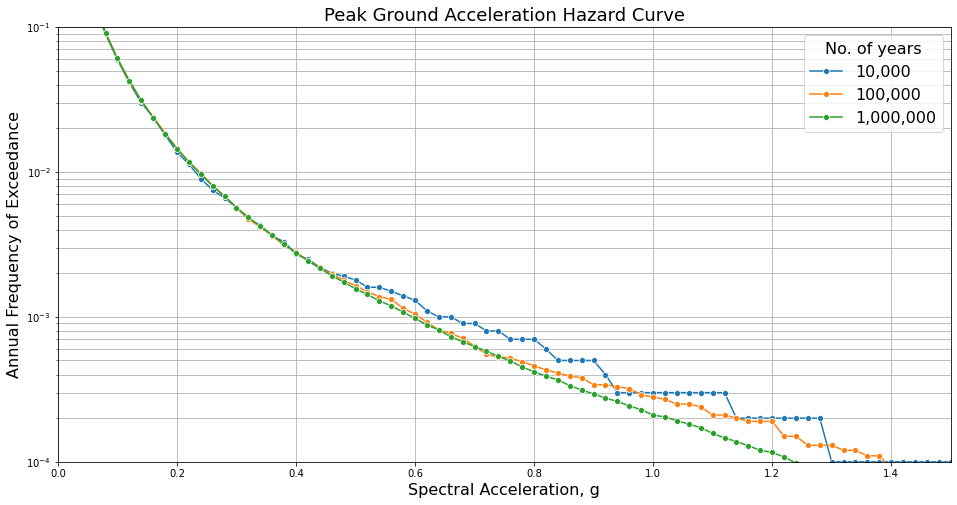

In [76]:
fig, ax = plt.subplots(figsize=(16,8))

sns.lineplot(data= hazard_df, x= 'spectral_acceleration', y='exceedance_rate_10000', marker='o')
sns.lineplot(data= hazard_df, x= 'spectral_acceleration', y='exceedance_rate_100000', marker= 'o')
sns.lineplot(data= hazard_df, x= 'spectral_acceleration', y='exceedance_rate_1000000', marker= 'o')

ax.set_title('Peak Ground Acceleration Hazard Curve', fontsize= 18)

ax.set_xlim(0,1.5)
ax.set_xlabel('Spectral Acceleration, g', fontsize=16)

ax.set_ylabel('Annual Frequency of Exceedance', fontsize=16)
ax.set_yscale("log")
ax.set_ylim(0.0001, 0.1)

ax.grid(True, which='both')
ax.legend(['10,000', '100,000', '1,000,000'], title= 'No. of years', fontsize=16, title_fontsize= 16);

The plot of hazard curves with varying number of years show that at lower probabilities of exceedance (more rare events), the tail end of the graph is not as defined as those with higher probabilities. Thus, a large number of samples is required to obtain more data points at the regions of lower probability. In the above simulation, the sampling of 10,000 years of earthquake still gives a bad approximation for probabilities lower than $10^{-3}$ and the total number of years should be extended. A smoother curve is obtained when the number of trials was extended to 1,000,000 years. Thus, the same number of years will be considered in the succeeding plots for other structural periods.

### Seismic Hazard Plot for Different Structural Periods

In [77]:
no_of_trials = 1_000_000
no_of_eq = np.random.poisson(mean_rate, no_of_trials).sum()
no_of_eq

6698716

The Monte Carlo simulation was iterated for varying structural periods to obtain the annual hazard curves of the site. A number of structural periods were considered between 0 and 5 seconds which will be used to construct the Uniform Hazard Spectra (UHS).

In [78]:
years= no_of_trials

hazard_df = pd.DataFrame()

periods = [0, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 0.7, 1, 1.5, 2 , 3, 4, 5]

for period in periods:
    
    df = monte_carlo(period, no_of_eq, 760)
    df_1 = pd.DataFrame(spectral_acc, columns=['spectral_acceleration'])
    df_1['period'] = period
    df_1['exceedance_rate'] = df_1['spectral_acceleration'].apply(
        lambda x: ((df.predicted > x).sum()/years) 
        if ((df.predicted > x).sum()/years)  != 0 
        else np.nan)
    hazard_df = pd.concat([hazard_df, df_1], ignore_index=True)
    
hazard_df

,spectral_acceleration,period,exceedance_rate
0,0.00,0.0,6.698716
1,0.02,0.0,0.692449
2,0.04,0.0,0.282079
3,0.06,0.0,0.149972
4,0.08,0.0,0.091712
...,...,...,...
2809,3.92,5.0,NaN
2810,3.94,5.0,NaN
2811,3.96,5.0,NaN
2812,3.98,5.0,NaN


Structures are designed with varying levels of earthquake hazard that are defined in terms of return period. Return period is the reciprocal of the annual frequency of exceedance and the code below adds a new column in the hazard dataframe that calculates the return period of each record.

In [79]:
hazard_df['return_period'] = hazard_df['exceedance_rate'].apply(lambda x: round(1/x,0) if x!= np.nan else x)
hazard_df

,spectral_acceleration,period,exceedance_rate,return_period
0,0.00,0.0,6.698716,0.0
1,0.02,0.0,0.692449,1.0
2,0.04,0.0,0.282079,4.0
3,0.06,0.0,0.149972,7.0
4,0.08,0.0,0.091712,11.0
...,...,...,...,...
2809,3.92,5.0,NaN,NaN
2810,3.94,5.0,NaN,NaN
2811,3.96,5.0,NaN,NaN
2812,3.98,5.0,NaN,NaN


### Plot of Seismic Hazard Curves

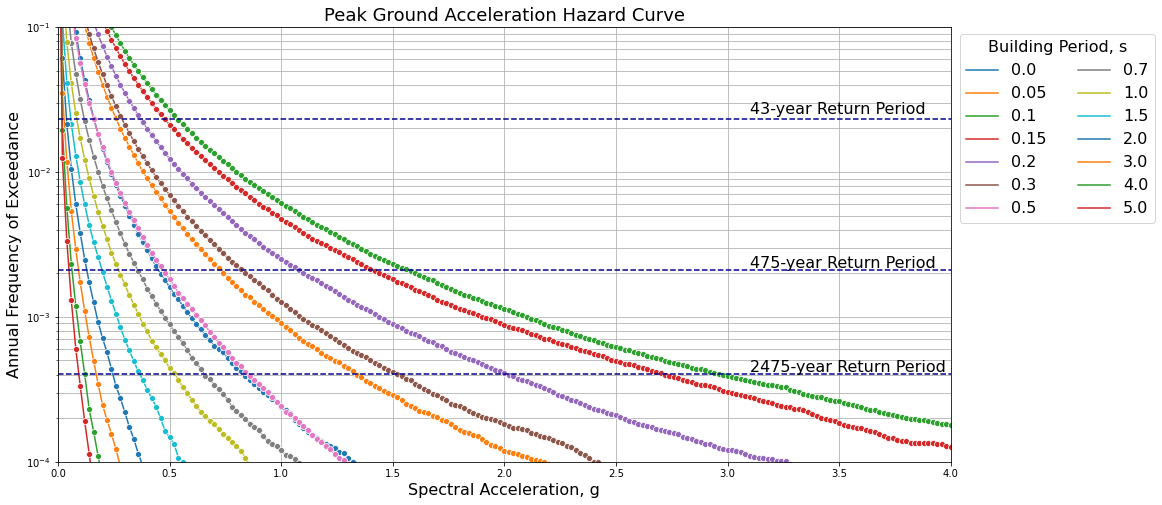

In [120]:
fig, ax = plt.subplots(figsize=(16,8))

sns.lineplot(data= hazard_df, x= 'spectral_acceleration', y='exceedance_rate', hue='period', palette='tab10', marker='o')

ax.set_title('Peak Ground Acceleration Hazard Curve', fontsize= 18)

ax.set_xlim(0,4.0)
ax.set_xlabel('Spectral Acceleration, g', fontsize=16)

ax.set_ylabel('Annual Frequency of Exceedance', fontsize=16)
ax.set_yscale("log")
ax.set_ylim(0.0001, 0.1)

ax.axhline(y=1/43, linestyle='--', color='darkblue')
ax.annotate('43-year Return Period', (3.1, 1/40), fontsize= 16)

ax.axhline(y=1/475, linestyle='--', color='darkblue')
ax.annotate('475-year Return Period', (3.1, 1/455), fontsize= 16)

ax.axhline(y=1/2475, linestyle='--', color='darkblue')
ax.annotate('2475-year Return Period', (3.1, 1/2400), fontsize= 16)

ax.grid(True, which='both')
ax.legend(ncol=2, title='Building Period, s',  fontsize=16, title_fontsize= 16, loc=(1.01, 0.55));

### Uniform Hazard Spectra

A Uniform Hazard Spectra (UHS) corresponds to spectral accelerations that have the same annual frequency of exccedance. Three levels of hazard are of particular interest in PSHA namely, Service-level Earthquake (43-year return period), Design-level Earthquake (475-year return period), and Maximum Considered Earthquake (2475-year return period).

In order to interpolate the spectral accelerations with equal return periods in the hazard dataframe, the `pivot_table` command is used to assign the structural periods as columns with the return periods as values.

In [81]:
spectrum = pd.pivot_table(hazard_df, index='spectral_acceleration', columns='period', values='return_period')
spectrum

period,0.00,0.05,0.10,0.15,0.20,0.30,0.50,0.70,1.00,1.50,2.00,3.00,4.00,5.00
spectral_acceleration,,,,,,,,,,,,,,
0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.02,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,5.0,9.0,16.0,29.0,51.0,80.0
0.04,4.0,2.0,1.0,1.0,1.0,2.0,4.0,7.0,13.0,24.0,47.0,85.0,176.0,301.0
0.06,7.0,3.0,2.0,2.0,2.0,3.0,7.0,13.0,24.0,47.0,95.0,186.0,429.0,769.0
0.08,11.0,5.0,2.0,2.0,3.0,5.0,12.0,21.0,39.0,77.0,167.0,343.0,842.0,1656.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3.92,500000.0,90909.0,5319.0,7463.0,17241.0,71429.0,333333.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.94,500000.0,90909.0,5405.0,7519.0,17241.0,76923.0,333333.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.96,500000.0,90909.0,5464.0,7576.0,17241.0,76923.0,333333.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The values of spectral acceleration for 43, 475, and 2475 return periods are interpolated for each structural period with the use of `np.interp()` method call which returns a linearly interpolated spectral acceleration from the pivoted dataframe above.

In [82]:
return_periods = [43, 475, 2475]
response_spectrum = pd.DataFrame()
rs_df = pd.DataFrame()

for year in return_periods:
    rs_df['building_period'] = spectrum.columns
    rs_df['return_period'] = year
    accel = []
    
    for column in spectrum.columns:
        accel.append(np.interp(year,spectrum[column],spectrum.index))
    rs_df['spectral_acceleration'] = accel
    response_spectrum = pd.concat([response_spectrum,rs_df], ignore_index=True)

response_spectrum

,building_period,return_period,spectral_acceleration
0,0.00,43,0.161667
1,0.05,43,0.260000
2,0.10,43,0.533333
3,0.15,43,0.475000
4,0.20,43,0.370000
5,0.30,43,0.286667
6,0.50,43,0.160000
7,0.70,43,0.116923
8,1.00,43,0.084000
9,1.50,43,0.056522


### Plot of Uniform Hazard Spectra

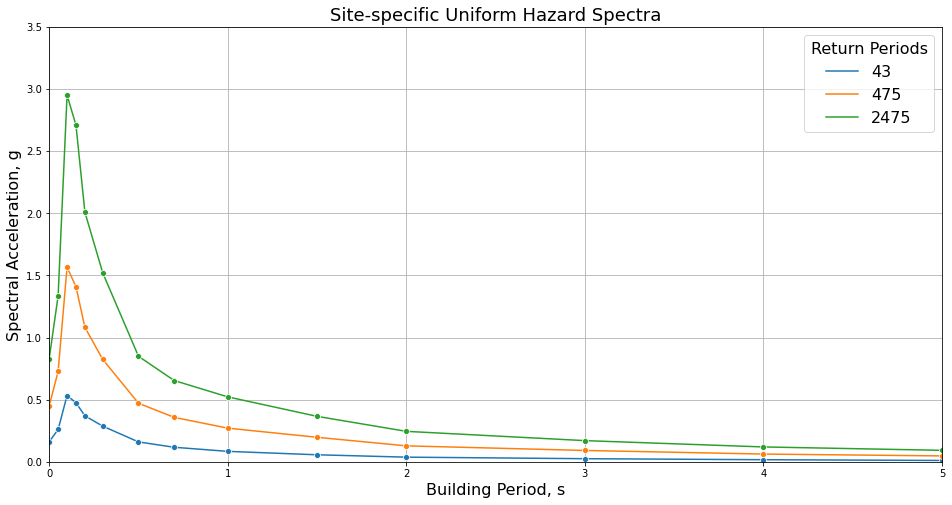

In [83]:
fig, ax = plt.subplots(figsize=(16,8))

sns.lineplot(data= response_spectrum, x= 'building_period', y='spectral_acceleration', 
             hue='return_period', palette='tab10', marker='o')

ax.set_title('Site-specific Uniform Hazard Spectra', fontsize= 18)

ax.set_xlim(0,5.0)
ax.set_xlabel('Building Period, s', fontsize=16)

ax.set_ylabel('Spectral Acceleration, g', fontsize=16)
ax.set_ylim(0, 3.5)

ax.grid(True, which='both')
ax.legend(title='Return Periods', fontsize=16, title_fontsize= 16);

### Results and Recommendations

One of the highlighted disadvantages of Monte Carlo Simulation is its long computation time since the iterations for creating synthetic catalogs are resource extensive. In the above study, the running time for the application of Monte Carlo function for all structural periods was no more than five minutes. Hence, the use of Python and the above algorithms has allowed the possibility of performing numerically expensive calculations such as forecasting earthquake occurrence and intensities to be accomplished easily. 

This notebook showcased the seismic hazard assessment for a single location but the framework should be extended to produce seismic hazard *maps* that would include hazards across a number of locations. In addition, more comprehensive ground motion prediction models should be used which consider other earthquake parameters that are integral to the characterization of uncertainties in earthquakes.



### References

* Baker, Jack W. (2015) Introduction to Probabilistic Seismic Hazard Analysis. White Paper Version 2.1, 77 pp.
* Kanno, T. (2006). A new attenuation relation for strong ground motion in Japan based on recorded data. Bulletin of the Seismological Society of America, 96(3), 879–897. https://doi.org/10.1785/0120050138 
* Musson, R. M. (2012). Psha validated by quasi observational means. Seismological Research Letters, 83(1), 130–134. https://doi.org/10.1785/gssrl.83.1.130 
* Musson, R. M. (2000). The use of Monte Carlo simulations for Seismic Hazard Assessment in the U.K. Annals of Geophysics, 43(1). https://doi.org/10.4401/ag-3617 
* Tang, C. C., Zhu, L., & Huang, R. (2016). Empiricalmw–ml,mb, andmsconversions in western China. Bulletin of the Seismological Society of America, 106(6), 2614–2623. https://doi.org/10.1785/0120160148 
* Wang, J. P., Huang, D., Chang, S.-C., & Wu, Y.-M. (2014). New evidence and perspective to the Poisson process and earthquake temporal distribution from 55,000 events around Taiwan since 1900. Natural Hazards Review, 15(1), 38–47. https://doi.org/10.1061/(asce)nh.1527-6996.0000110 